In [36]:
from data import load, split, ScaleAbsOne
from gpytorch.constraints import Positive
import torch
import math
import gpytorch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [44]:
df = load()
train_set, dev_set, test_set = split(df, "new_dose-response_matrices", inner_fold=1, outer_fold=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


In [45]:
train_target = train_set.pop("PercentageGrowth")
dev_target = dev_set.pop("PercentageGrowth")
test_target = test_set.pop("PercentageGrowth")
scaler = ScaleAbsOne()
train_set = scaler.fit_transform(train_set.values)
dev_set = scaler.transform(dev_set.values)
test_set = scaler.transform(test_set.values)

In [56]:
sub = torch.tensor(train_set[:150]).float()
subt = torch.tensor(train_target[:150].values).float()

In [57]:
# sub = torch.randn(150, 400)
# subt = torch.randn()

In [58]:
def train(model, likelihood, training_iter, x, y):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    pbar = tqdm(range(training_iter)) 
    for i in pbar:
        optimizer.zero_grad()
        output = model(x)
        loss = -mll(output, y)
        pbar.set_description(f'{loss.item():.2e}')
        loss.backward()
        optimizer.step()

In [59]:
class MultiLinearKernel(gpytorch.kernels.Kernel):
    is_stationary = False
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)
        
        self.register_parameter(
            name='raw_length', 
            parameter=torch.nn.Parameter(torch.ones(*self.batch_shape, 1, 1, 400) * 100)
        )
        if length_constraint is None:
            length_constraint = Positive()
        self.register_constraint("raw_length", length_constraint)

        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    @property
    def length(self):
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    def forward(self, x1, x2, **params):
        # This is expensive, but I'm not sure how to improve it
        # For the Gram at least it's a symmetric tensor
        # We could do it iteratively and at least save some RAM
        prod = torch.einsum("nd, md -> nmd", x1, x2)
        frac = (self.length**2 + prod) / (1 + self.length**2)
        return frac.prod(-1)
    
    
class MultiLinearGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = MultiLinearKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [60]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MultiLinearGPModel(sub, subt, likelihood)

model.train()
likelihood.train()
train(model, likelihood, 1000, sub, subt)

model.eval()
likelihood.eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

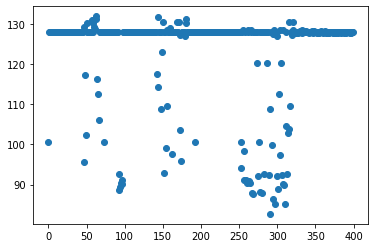

In [63]:
plt.scatter(range(sub.shape[-1]), model.covar_module.length.detach().cpu().numpy())